In [1]:
import pandas

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [12]:
# Change the directories to the base (LLM causality) and Tables folder
BASE_DIR = '/content/drive/MyDrive/LLM causality'
TABLE_DIR = '/content/drive/MyDrive/LLM causality/Tables/'

In [10]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

def get_top_eigenvalues(csv_file, cols, max_cpn = 6):
    """
    Reads a CSV file, performs PCA on specified columns, and returns the top 6 eigenvalues.

    Args:
        csv_file (str): Path to the CSV file.
        c1 (int): Starting column index (inclusive).
        c2 (int): Ending column index (exclusive).

    Returns:
        numpy.ndarray: An array of the top 6 eigenvalues.
                      Returns None if an error occurs or if there aren't enough eigenvalues
    """
    try:
        df = pd.read_csv(csv_file)
        # Handle potential 'Unnamed: 0' column
        if 'Unnamed: 0' in df.columns:
            df = df.drop(columns=['Unnamed: 0'])

        # Select specified columns and convert to numeric
        features = df.iloc[:, cols]
        for col in features.columns:
            features[col] = pd.to_numeric(features[col], errors='coerce')


        # Handle missing values (replace with the mean of the column)
        features = features.fillna(features.mean())

        # Normalize the data to unit Frobenius norm
        x = StandardScaler().fit_transform(features)


        pca = PCA()
        pca.fit(x)
        eigenvalues = pca.explained_variance_
        s = np.sum(eigenvalues**2) ** 0.5
        eigenvalues /= s

        return eigenvalues[:max_cpn]  # Return top 6 eigenvalues

    except FileNotFoundError:
        print(f"Error: File not found at {csv_file}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [19]:
%%capture
import matplotlib.pyplot as plt

files_and_params = {
    'safetybench.csv': list(range(3, 10)),
    'decoding_trust.csv': list(range(1, 10)),
    'mteb.csv': list(range(1, 133)),  # Use all columns for mteb.csv
    'libra.csv': list(range(1, 59)),
    'open_llm_leaderboard.csv': [19, 21, 23, 25, 27, 29],
    'open_llm_official.csv': [19, 21, 23, 25, 27, 29]
}

eigenvalues_dict = {}
for filename, cols in files_and_params.items():
    filepath = TABLE_DIR + filename
    eigenvalues = get_top_eigenvalues(filepath, cols, max_cpn = 15)
    print(eigenvalues)
    if eigenvalues is not None:
        eigenvalues_dict[filename] = eigenvalues

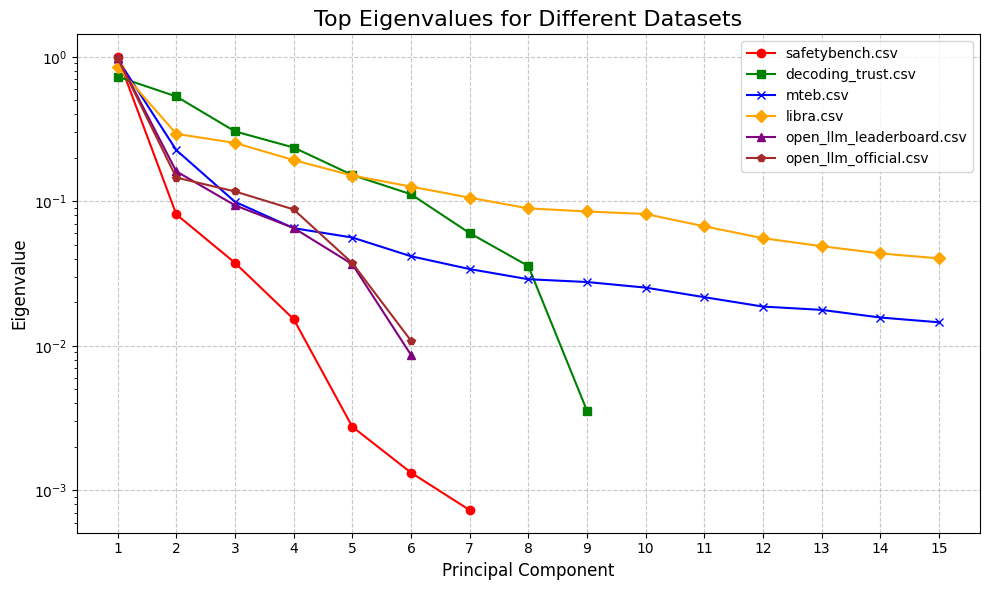

In [21]:
# Plotting
plt.figure(figsize=(10, 6))

markers = ['o', 's', 'x', 'D', '^', 'p']  # Different markers for each file
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown']

for i, (filename, eigenvalues) in enumerate(eigenvalues_dict.items()):
    plt.plot(range(1, len(eigenvalues) + 1), eigenvalues,
             marker=markers[i % len(markers)], linestyle='-',
             label=filename, color=colors[i % len(colors)])


plt.title('Top Eigenvalues for Different Datasets', fontsize=16)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Eigenvalue', fontsize=12)
plt.yscale('log')  # Logarithmic scale for better visibility
plt.xticks(range(1, 16))  # Ensure ticks are only for the top 6
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best', fontsize=10)


plt.tight_layout()  # Adjust layout for better spacing
plt.show()